In [ ]:
!pip install imblearn

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import sklearn
import joblib 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from collections import Counter
import applicationinsights
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import imblearn
from imblearn.over_sampling import SMOTE
import azureml
from azureml.core import Environment, Workspace, Experiment, Run, Dataset
from azureml.core.model import Model, InferenceConfig
from azureml.core.webservice import AciWebservice, Webservice
import json
import requests

print('The azureml.core version is {}'.format(azureml.core.VERSION))

The azureml.core version is 1.48.0


Connecting to workspace

In [ ]:
# df = spark.sql("select * from transactions").toPandas()
# display(dataset)

subscription_id = xxxx
resource_group = 'tomirg'
workspace_name = 'tomiws'

workspace = Workspace(subscription_id, resource_group, workspace_name)

df = Dataset.get_by_name(workspace, name='Financial_transaction').to_pandas_dataframe()

#Exploratory Data Analysis

In [ ]:
#reads first 5 rows of dataset
df.head(5)

,Column1,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,0,2023-01-01 00:00:31,596,3156,533.07,31,0,0,0
1,1,1,2023-01-01 00:02:10,4961,3412,808.56,130,0,0,0
2,2,2,2023-01-01 00:07:56,2,1365,1442.94,476,0,1,1
3,3,3,2023-01-01 00:09:29,4128,8737,620.65,569,0,0,0
4,4,4,2023-01-01 00:10:34,927,9906,490.66,634,0,0,0


In [ ]:
#Shape of the dataset
rows, cols = df.shape
print('There are {} rows in the dataset'.format(rows), '\nThere are {} columns in the dataset'.format(cols))

There are 1048575 rows in the dataset 
There are 10 columns in the dataset


In [ ]:
# Information about the data set
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype         
---  ------             --------------    -----         
 0   Column1            1048575 non-null  int64         
 1   TRANSACTION_ID     1048575 non-null  int64         
 2   TX_DATETIME        1048575 non-null  datetime64[ns]
 3   CUSTOMER_ID        1048575 non-null  int64         
 4   TERMINAL_ID        1048575 non-null  int64         
 5   TX_AMOUNT          1048575 non-null  float64       
 6   TX_TIME_SECONDS    1048575 non-null  int64         
 7   TX_TIME_DAYS       1048575 non-null  int64         
 8   TX_FRAUD           1048575 non-null  int64         
 9   TX_FRAUD_SCENARIO  1048575 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(8)
memory usage: 80.0 MB


In [ ]:
#Descriptive statistics of numerical variables
df.describe().round(2)

,Column1,TRANSACTION_ID,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
count,1048575.00,1048575.00,1048575.00,1048575.00,1048575.00,1048575.00,1048575.00,1048575.00,1048575.00
mean,524287.00,524287.00,2504.49,4997.33,538.17,4722136.95,54.16,0.13,0.14
std,302697.67,302697.67,1445.67,2885.75,882.43,2726923.03,31.56,0.34,0.39
min,0.00,0.00,0.00,0.00,0.00,31.00,0.00,0.00,0.00
25%,262143.50,262143.50,1253.00,2503.00,180.16,2367256.50,27.00,0.00,0.00
50%,524287.00,524287.00,2506.00,4993.00,422.20,4715511.00,54.00,0.00,0.00
75%,786430.50,786430.50,3765.00,7495.00,750.90,7088192.50,82.00,0.00,0.00
max,1048574.00,1048574.00,4999.00,9999.00,77212.50,9454063.00,109.00,1.00,3.00


In [ ]:
# Checking for missing numbers
df.isna().sum()

Out[18]: _c0                  0
TRANSACTION_ID       0
TX_DATETIME          0
CUSTOMER_ID          0
TERMINAL_ID          0
TX_AMOUNT            0
TX_TIME_SECONDS      0
TX_TIME_DAYS         0
TX_FRAUD             0
TX_FRAUD_SCENARIO    0
dtype: int64

In [ ]:
#Function to plot piecharts
def plot_piechart(column):
    fraud = 0
    no_fraud = 0

    for i in column:
        if i == 1:
            fraud += 1
        else:
            no_fraud +=1 

    fraud = (fraud / len(column)) * 100
    no_fraud = (no_fraud / len(column)) * 100

    x = ['Fraud (1)', "No fraud (0)"]
    y = [fraud, no_fraud]

    explode = (0.2, 0)

    fig1, ax1 = plt.subplots()
    ax1.pie(y, explode=explode, labels=x, autopct='%1.1f%%',
            shadow=True, startangle=110)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Proportion of fraud cases',fontsize=25)
    return plt.show()

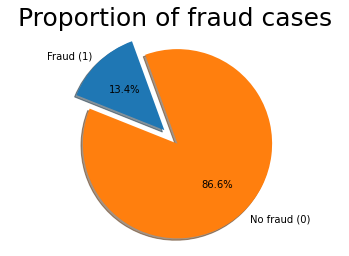

In [ ]:
plot_piechart(df['TX_FRAUD'])

In [ ]:
# Segregating the date variable into individual components for deeper analysis
#
df["TX_weekday"]=pd.DatetimeIndex(df["TX_DATETIME"]).weekday
df["TX_month"]=pd.DatetimeIndex(df["TX_DATETIME"]).month
df["TX_Year"]=pd.DatetimeIndex(df["TX_DATETIME"]).year

In [ ]:
#Shape of the dataset
rows, cols = df.shape
print('Now, there are {} rows in the dataset'.format(rows), '\nNow there are {} columns in the dataset'.format(cols))

Now, there are 1048575 rows in the dataset 
Now there are 13 columns in the dataset


There transaction were completed in all 7 days of the week. And For 4 months in 1 year. 

In [ ]:
# Now there are 13 colums in the dataset
df.shape[1]

Out[87]: 13

# Model training

In [ ]:
# creating an experiment in the workspace
experiment = Experiment(workspace=ws, name='fraud-detection-experiment')
run = experiment.start_logging()
print("Starting experiment:", experiment.name)

Starting experiment: fraud-detection-experiment


In [ ]:
# Some columns are not used in the prediction. This is because; 'TX_Year' only has 2023 parameter,
# 'TX_FRAUD_SCENARIO' would cause data leakage, because it states the type of fraud that occurred. 
# The other removed variables identify the clients; 'Column1', 'TX_DATETIME', 
# 'TRANSACTION_ID', 'CUSTOMER_ID', 'TERMINAL_ID', 'TX_Year', 'TX_FRAUD_SCENARIO'.

    
numerical_variables = ['TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS']
categorical_variables = ['TX_weekday', 'TX_month']
    
# Scaling numerical variables for better model performance    
sc= StandardScaler()
numerical_transformations = pd.DataFrame(sc.fit_transform(df[numerical_variables]))

# Encoding categorical variables for better model performance    
enc = OneHotEncoder(handle_unknown= 'ignore', sparse_output = True)
categorical_transformations = pd.DataFrame(enc.fit_transform(df[categorical_variables]).toarray())

# Segregating the predictors from the target variable
features = pd.concat([numerical_transformations, categorical_transformations], axis = 1)
target = df['TX_FRAUD']

In [ ]:
# splitting data into train(80%) and test(20%) sets
x_train, x_test, y_train, y_test = train_test_split(
    features.values, target.values, random_state = 42, test_size= 0.2)

<Axes: ylabel='count'>

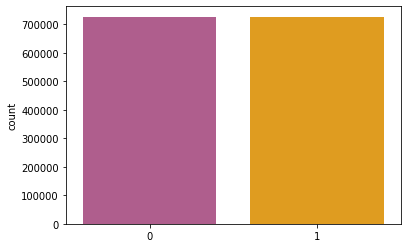

In [ ]:
# Oversampling train set to overcome data imbalance
smote = SMOTE(random_state = 42)
x_train, y_train = smote.fit_resample(x_train, y_train)
    
Counter(y_train)
sns.countplot(x=y_train,palette= ["#bc5090", "#ffa600"])

The not fraud (0) and the fraud (1) categories are now equal

In [ ]:
# Creating a simple RF model
model = RandomForestClassifier(n_estimators= 100, criterion= "gini",max_depth= 10, min_samples_split= 2,random_state= 42)

# Fitting the model on train data   
model.fit(x_train, y_train)
    #cv_score = model.best_score_

# Making predictions on test data   
y_predict = model.predict(x_test)
y_actual= y_test

# Getting and logging the metrics    
Accuracy = accuracy_score(y_actual, y_predict)
run.log('Accuracy', Accuracy)
Recall = recall_score(y_actual, y_predict)
run.log('Recall', Recall)
Precision = precision_score(y_actual, y_predict)
run.log('Precision', Precision)
F1= f1_score(y_actual, y_predict)
run.log('F1', F1)
AUC = roc_auc_score(y_actual, y_predict)
run.log('AUC', AUC)

The obtained metrics can be seen in the image below

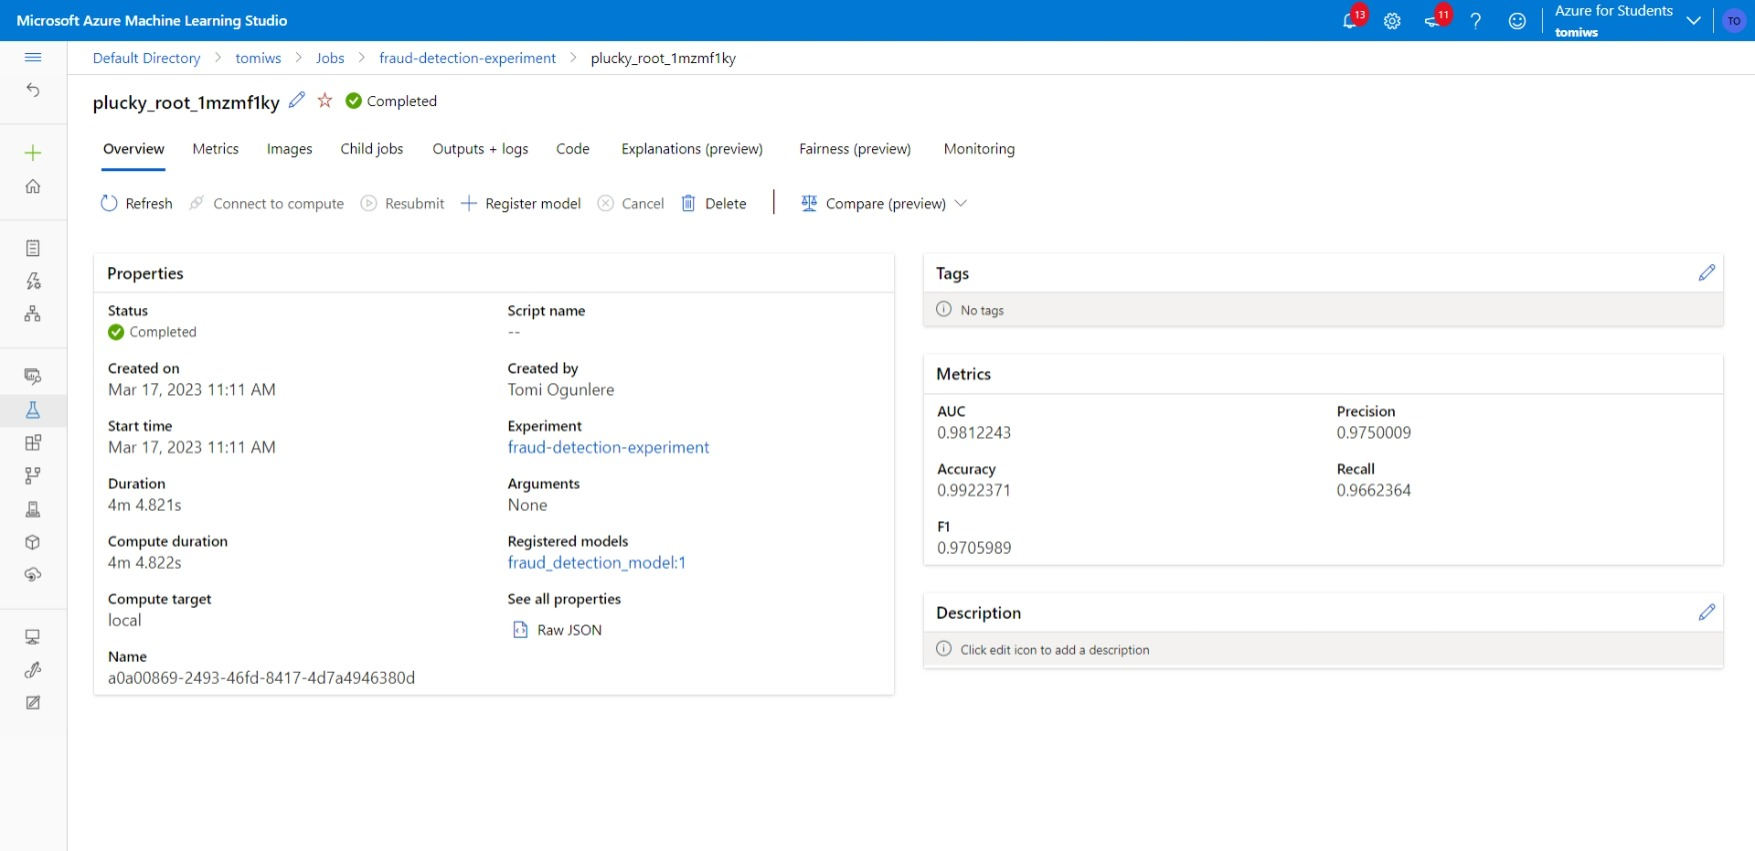

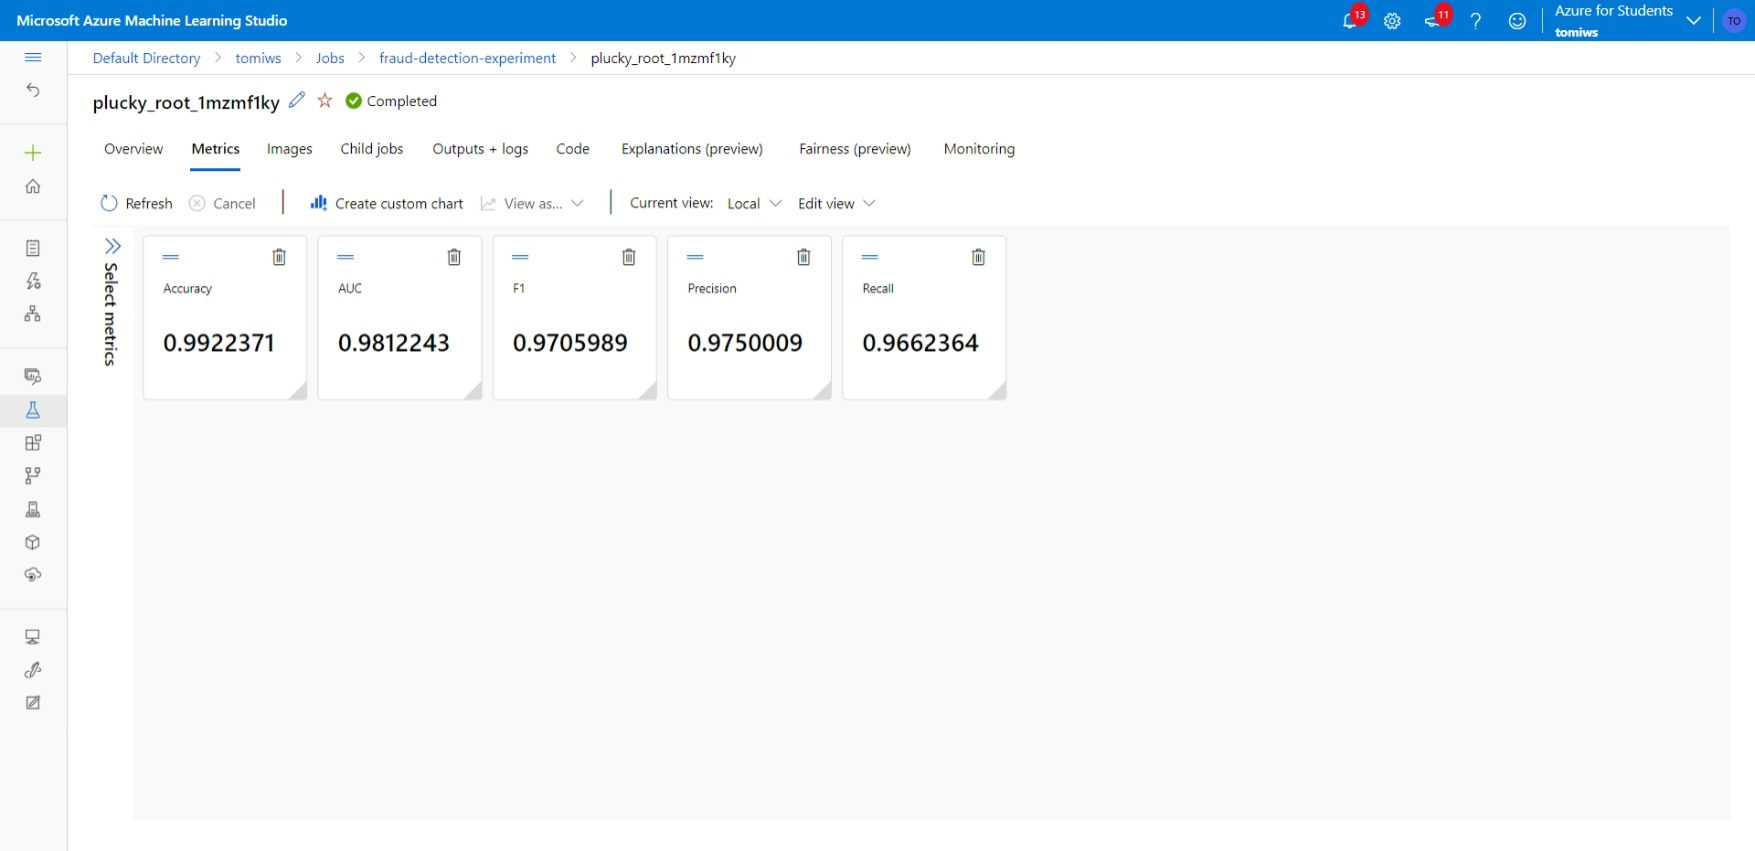

Save and register the model

In [ ]:
# Save trained model
model_file = 'fraud_detection_model.pkl'
joblib.dump(value=model, filename=model_file)
run.upload_file(name = 'outputs/' + model_file, path_or_stream = './' + model_file)

# Complete the run
run.complete()

# Registering model
print('Registering model...')
run.register_model(model_path='outputs/fraud_detection_model.pkl', model_name='fraud_detection_model',
                   tags={'Training context':'Inline Training'},
                   properties={'AUC': run.get_metrics()['AUC'],'F1': run.get_metrics()['F1'],
                   'Recall': run.get_metrics()['Recall'],'Precision': run.get_metrics()['Precision'],
                    'Accuracy': run.get_metrics()['Accuracy']})

# Get the registered model
model = ws.models['fraud_detection_model']

print('Model trained and registered.')

Registering model...
Model trained and registered.


A supervised machine learning model has been trained and registered. The model classifies transactions based on the likelihood of them being fraudulent. This Fraud detection model could be used in a production environment. For instance, a bank where fraudulent transactions need to be prohibited, or an online payment service where dubious transactions need to be flagged or blocked. To use this model in situations such as the aforementioned, the model could be deployed the model as a web service.

# Script for new data

In [ ]:
# Create deployment files folder
deployment_folder = './fraud_detection_service'
os.makedirs(deployment_folder, exist_ok=True)
print(deployment_folder, 'folder created.')

# Set path for scoring script
script_file = 'score.py'
script_path = os.path.join(deployment_folder,script_file)

./fraud_detection_service folder created.


# Model Deployment

Scoring script for new data.

In [7]:
%%writefile score.py
import json
import joblib
import numpy as np
import os
import sklearn

# Called when the web service is loaded
def init():
    global model
    # Get and load saved model
    model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'fraud_detection_model.pkl')
    model = joblib.load(model_path)

# Called after a request
def run(raw_data):
    # Gets input data as a numpy array
    data = json.loads(raw_data)['data']
    np_data = np.array(data)
    # using saved model to predict
    predictions = model.predict(np_data)
    
    # print data and predictions (so they will be logged!)
    log_text = 'Data:' + str(data) + ' - Predictions:' + str(predictions)
    print(log_text)
    
    # Note: category 0= (not fraud), and category 1= (fraud)
    category = ['not-fraud', 'fraud']
    predicted_category = []
    for prediction in predictions:
        predicted_category.append(category[prediction])
    # Returns predictions as JSON
    return json.dumps(predicted_category)

Overwriting score.py


The service will be deployed as an Azure Container instance.

In [ ]:
# Configure the scoring environment
aci_service_env = Environment(name='aci_service-env')

# Packages required to run the web service
python_packages = ['scikit-learn', 'azureml-defaults', 'azure-ml-api-sdk']

# Function to install listed packages
for package in python_packages:
  '''Function to install required dependencies'''

    aci_service_env.python.conda_dependencies.add_pip_package(package)

# Use scoring script to make inference in the service environment
inference_config = InferenceConfig(source_directory=deployment_folder,
                                   entry_script=script_file,
                                   environment=aci_service_env)

# Configure web service container
deployment_config = AciWebservice.deploy_configuration(cpu_cores=1, memory_gb=1)

# Deploying the model as a web service
print('Deploying model...')
service_name = "fraud-detection-service"
aci_service = Model.deploy(ws, service_name, [model], inference_config, deployment_config, overwrite=True)
aci_service.wait_for_deployment(show_output = True)
print(aci_service.state)

Deploying model...
Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2023-03-17 10:17:00+00:00 Creating Container Registry if not exists..
2023-03-17 10:27:00+00:00 Registering the environment.
2023-03-17 10:27:02+00:00 Building image..
2023-03-17 10:37:18+00:00 Generating deployment configuration.
2023-03-17 10:37:19+00:00 Submitting deployment to compute..
2023-03-17 10:37:25+00:00 Checking the status of deployment fraud-detection-service..
2023-03-17 10:39:11+00:00 Checking the status of inference endpoint fraud-detection-service.
Succeeded
ACI service creation operation finished, operation "Succeeded"
Healthy


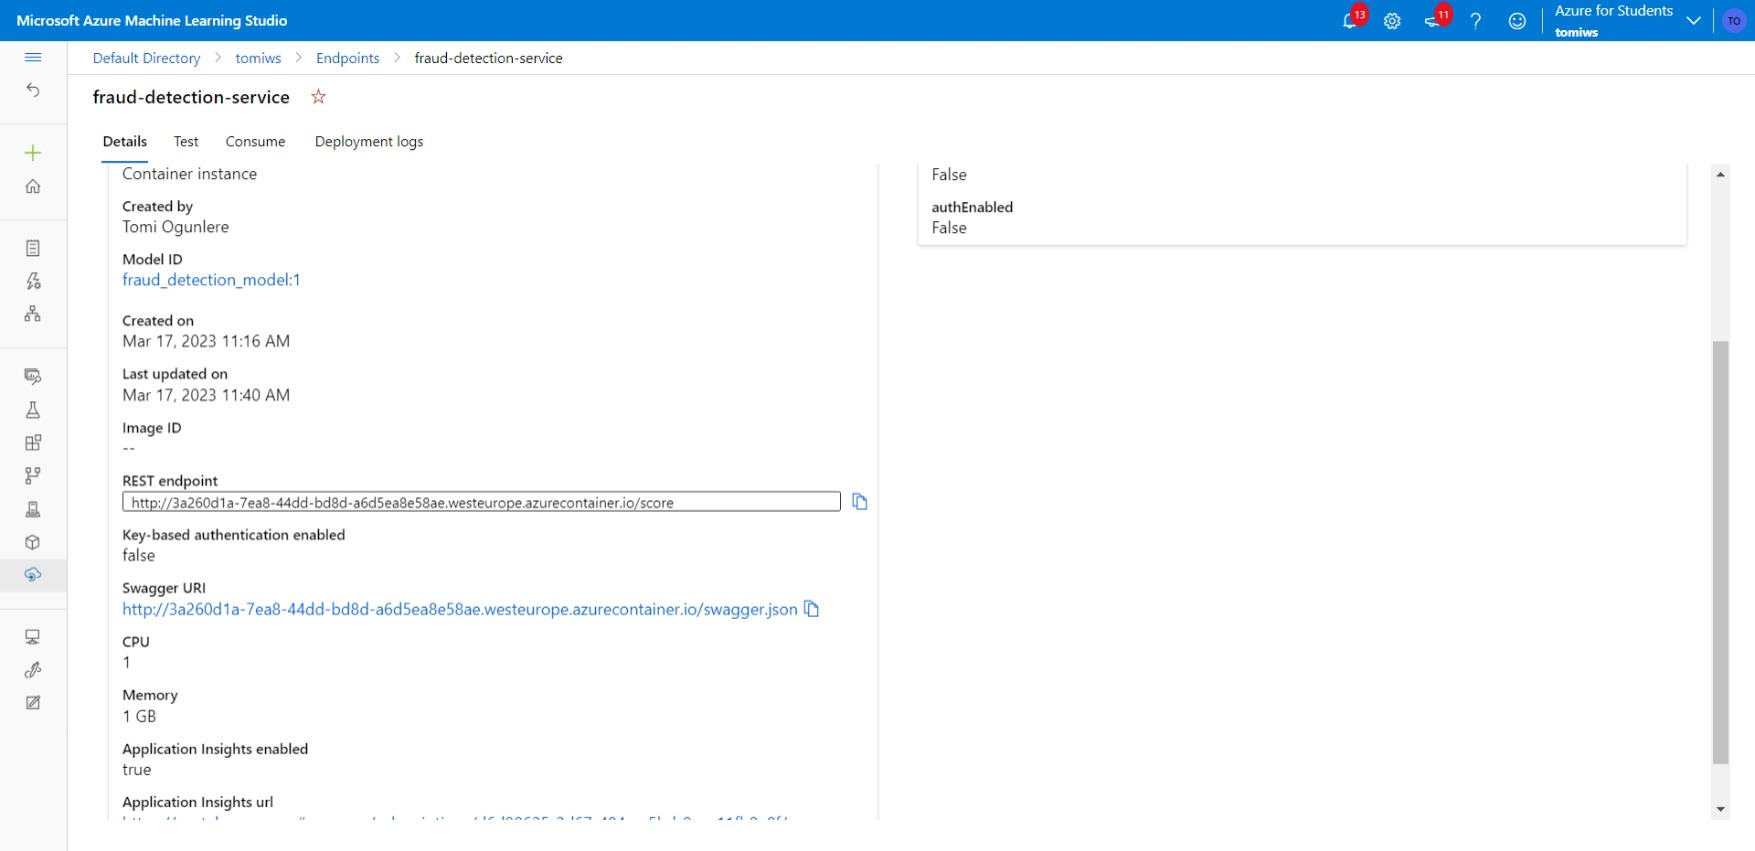

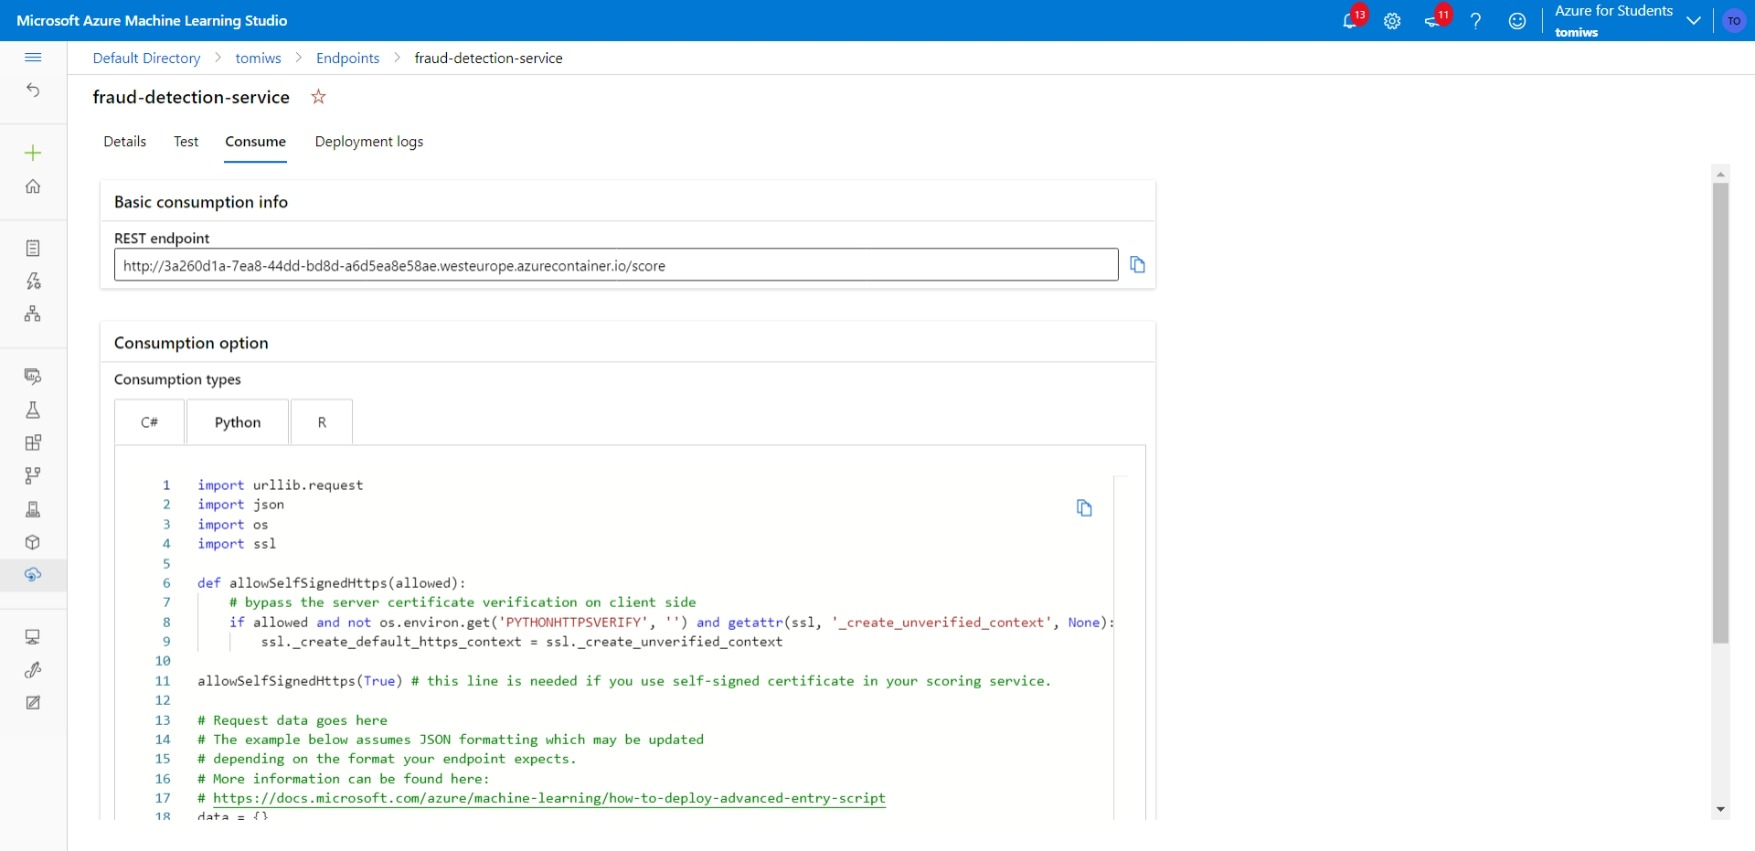

# Using the web service application

The web service can be consumed from the client's application. For example, a bank app. 

---



#Enable Application Insight

In [ ]:
# Enable AppInsights
aci_service.update(enable_app_insights=True)
print('AppInsights enabled!')

AppInsights enabled!


Getting the endpoint uri where applications submit http requests to.

In [ ]:
endpoint = aci_service.scoring_uri
print(endpoint)

http://3a260d1a-7ea8-44dd-bd8d-a6d5ea8e58ae.westeurope.azurecontainer.io/score


# New data entry

In [ ]:
# Create new data for inferencing
x_new = [[0.250450,	-1.731625,	-1.715834,	0.0, 0.0,	0.0,	0.0,	0.0,	0.0,	1.0,	0.0,	0.0,	0.0, 0.0],
         [1.100345,	-1.731499,	-1.73638,	0.0,	0.0,	0.0,	0.0,	0.0,	0.0,	0.0,	1.0,	0.0,	0.0,	0.0]]

# Converts array to list in JSON
input_json = json.dumps({"data": x_new})

# Content type
headers = { 'Content-Type':'application/json' }

# Get predictions using url, JSON list, and the content type
predictions = requests.post(endpoint, input_json, headers = headers)
print(predictions.status_code)
# Status code 200 means request successful
if predictions.status_code == 200:
    predicted_classes = json.loads(predictions.json())
    for i in range(len(x_new)):
        print ("Transaction {}".format(x_new[i]), predicted_classes[i] )

200
Transaction [0.25045, -1.731625, -1.715834, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0] not-fraud
Transaction [1.100345, -1.731499, -1.73638, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0] fraud


The Deployment logs

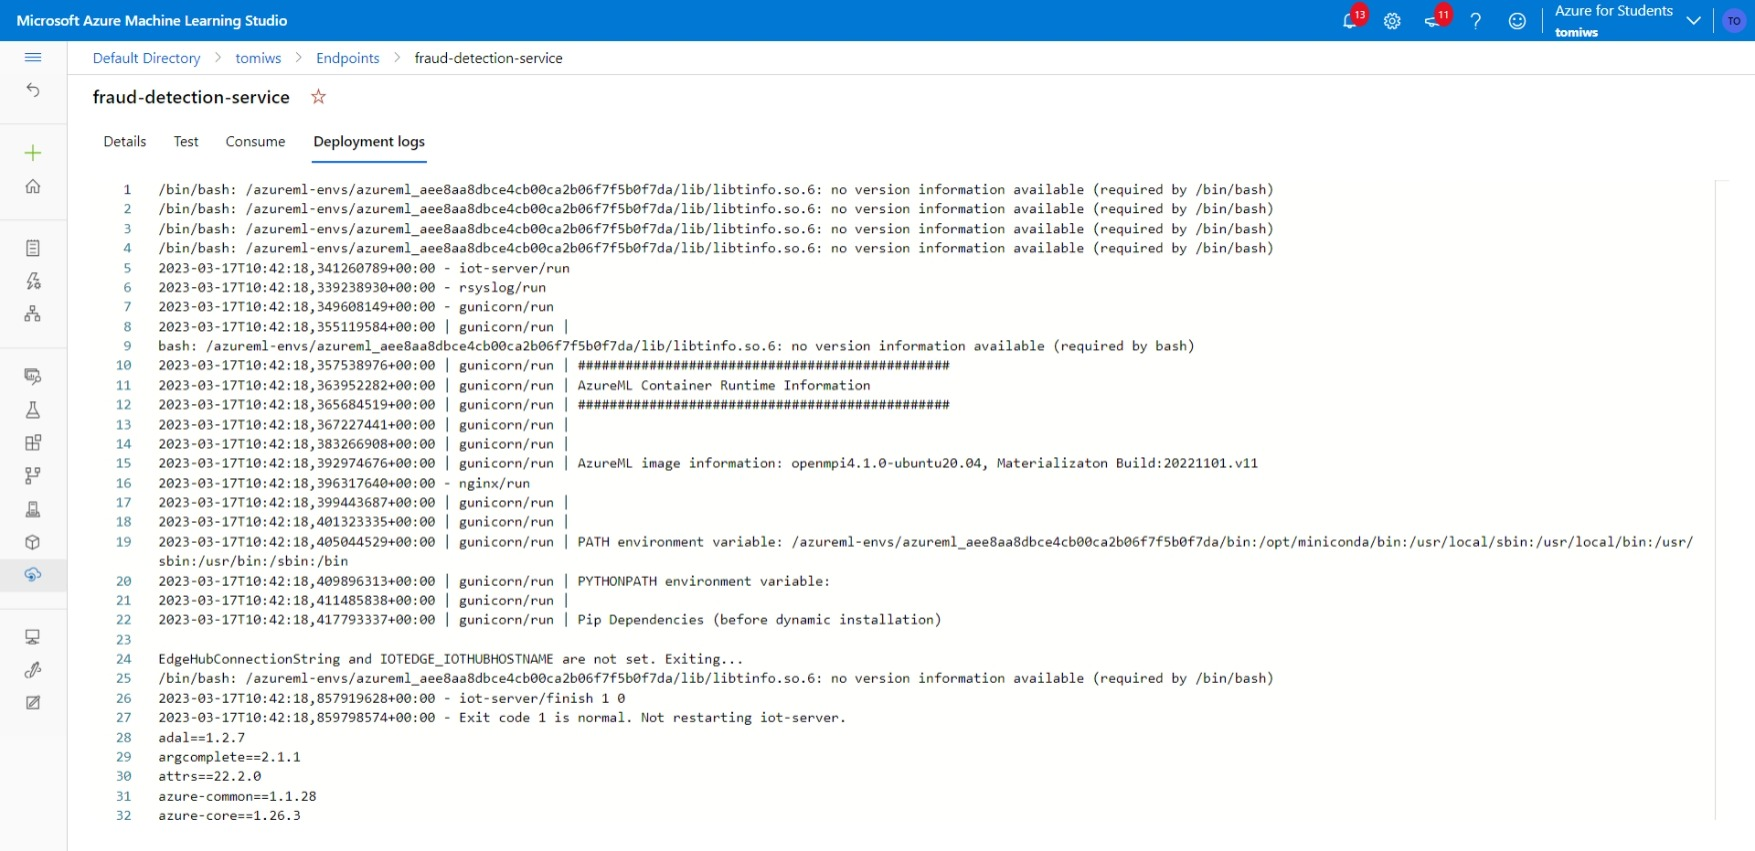

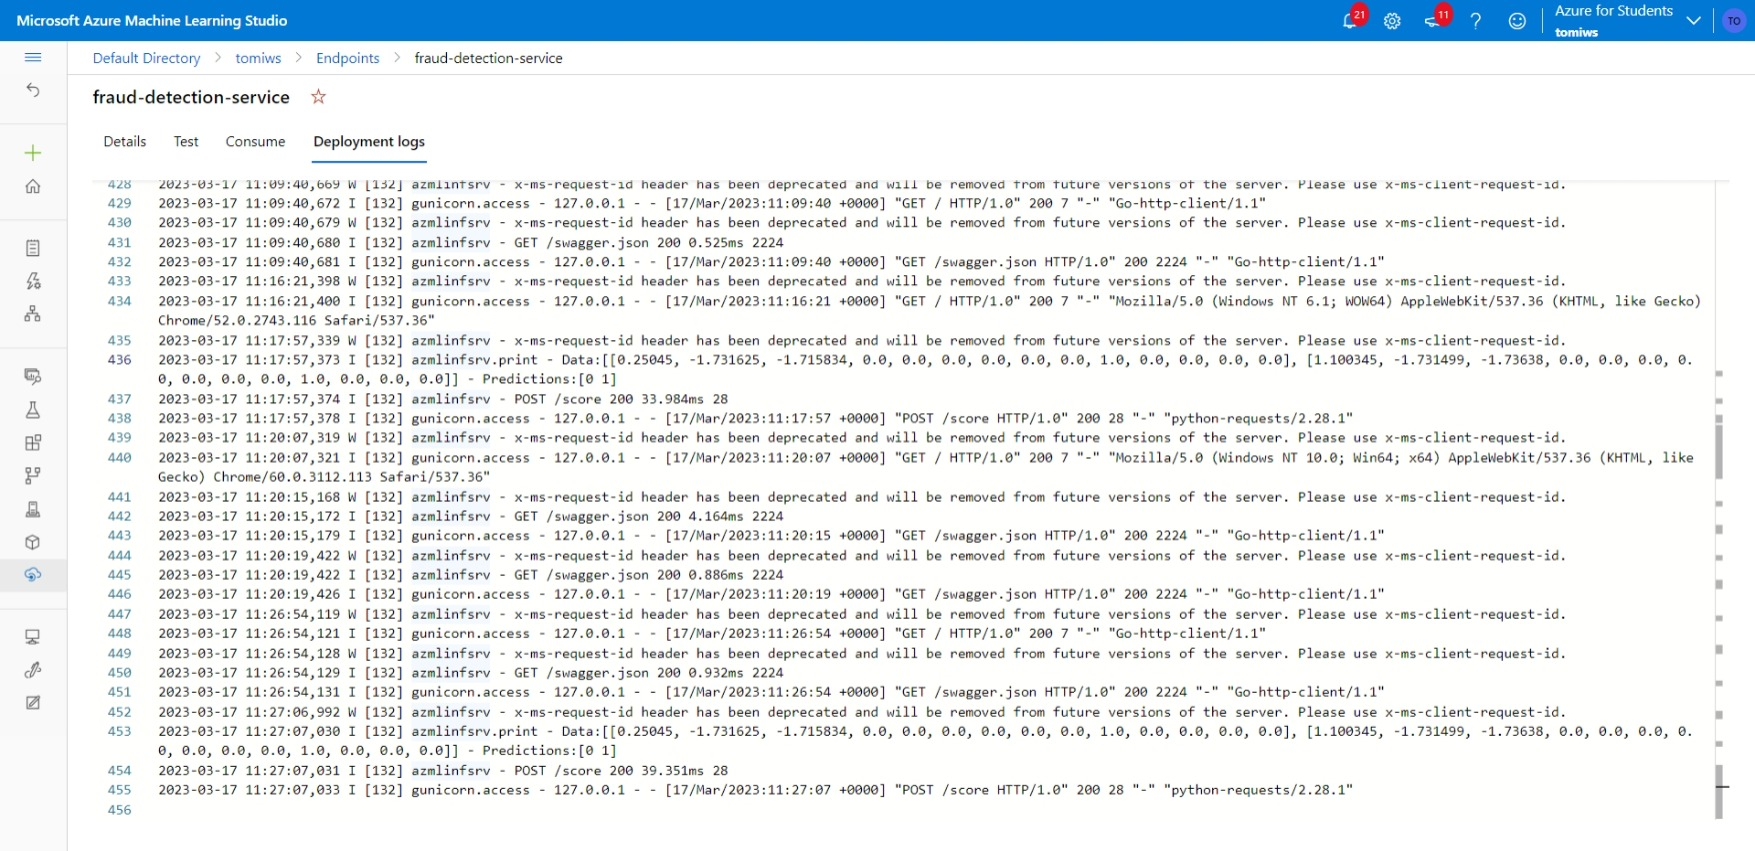

Monitoring the peformance of the app through the Application insights.

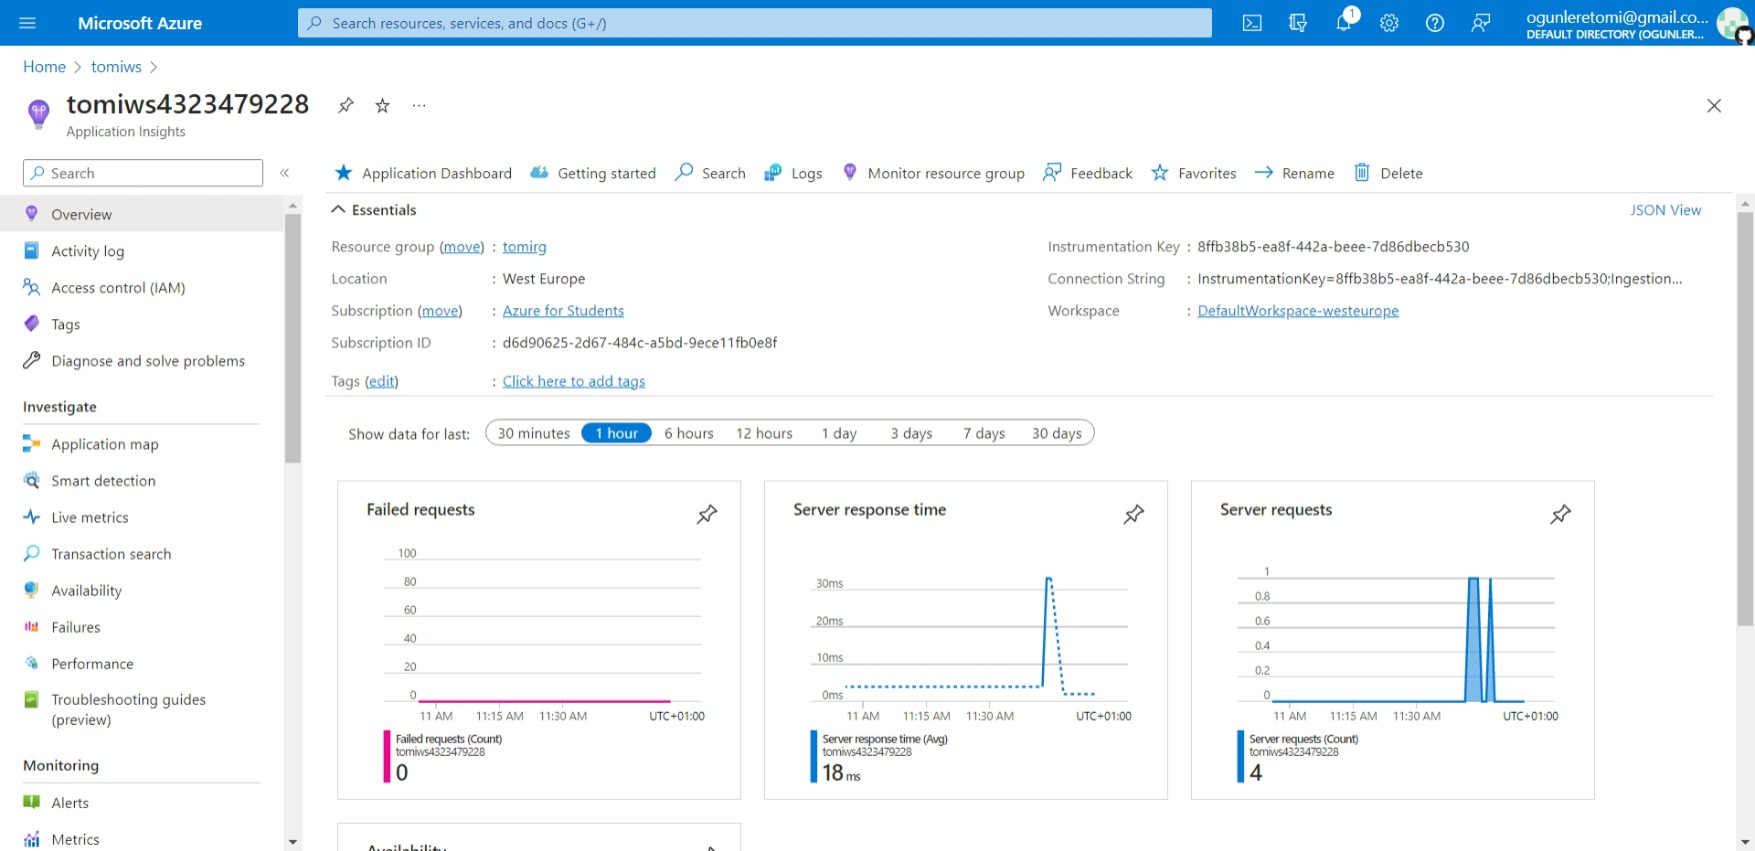

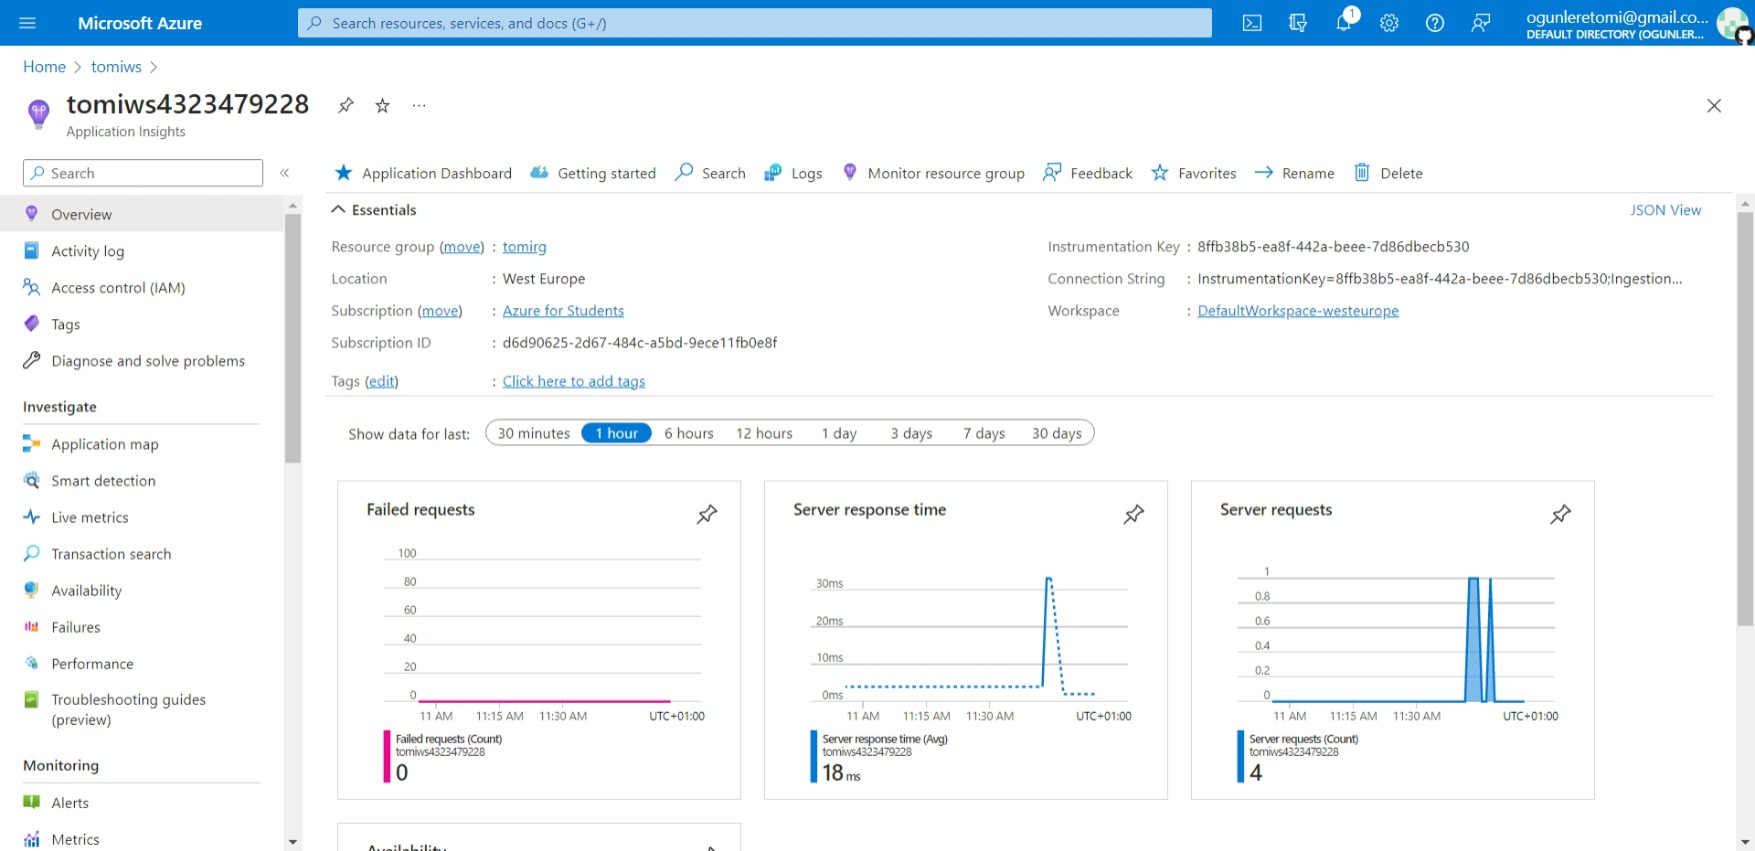